In [1]:
#instalando bibilioteca pandas
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install lime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#importando pacotes e bibliotecas para um SVM

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
#from sklearn.feature_extraction.text import CountVectorizer #converter os textos em uma matriz
from sklearn.feature_extraction.text import TfidfTransformer #frequencia que o termo aparece

#from sklearn.svm import LinearSVC, SVC # dados lineares / não lineares

In [3]:
#importando dataset

df = pd.read_csv("all-data.csv")

In [4]:
df.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
df.shape

(4846, 2)

<Axes: xlabel='sentiment', ylabel='count'>

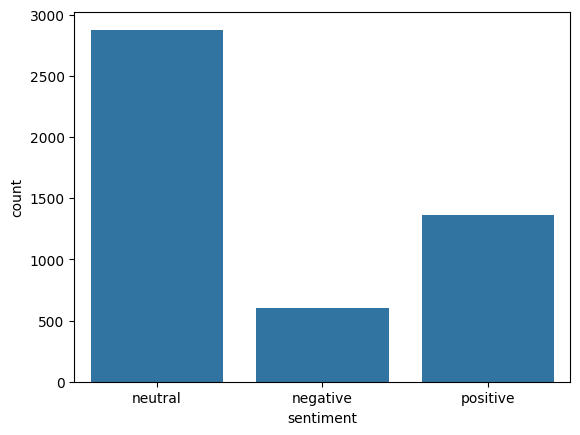

In [6]:
#exibindo os dados em um gráfico de barras
sns.countplot(x='sentiment', data=df)

**Pré-processamento**

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
#nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CADASTRO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [10]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

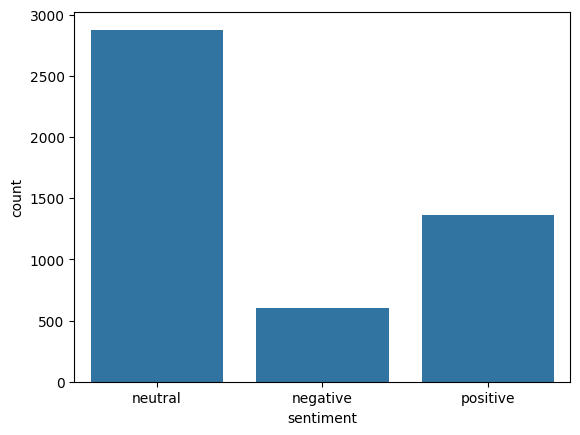

In [11]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

TREINAMENTO

In [12]:
# Assuming 'text' is the column name containing the text data and 'sentiment' is the target column
X = df['text']
y = df['sentiment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["sentiment"], test_size=0.2, random_state=42)

In [14]:
# Import necessary libraries for the pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC

# Define and fit the pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('vect', CountVectorizer()),  # Convert text to numerical features
    ('tfidf', TfidfTransformer()),  # Apply TF-IDF transformation
    ('clf', LinearSVC()),  # Use a LinearSVC classifier (you can change this to another classifier)
])
pipeline.fit(X_train, y_train)  # Train the pipeline on the training data

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [15]:
#exibindo 5 dados de teste
print(X_test.head(101))

3207    company supposed deliver machinery veneer mill...
1684    unc charlotte would also deploy ssh tectia con...
1044    lee man combined annual production capacity cl...
4145    high figure european scale noop said recalling...
1538    finland corresponding service alma medium etuo...
                              ...                        
3500    total six polled analyst rated mreal two gave ...
3036    mreal part finnish paper maker metsaliitto gro...
3014    adp news nov finnish powersupply solution prov...
4149        total stock option issued stock option scheme
3598    following transaction tulikivi restructured op...
Name: clean_text, Length: 101, dtype: object


**LIME**

In [18]:
from IPython.display import display
from lime.lime_text import LimeTextExplainer

# Criando o explainer
explainer = LimeTextExplainer(class_names=list(pipeline.classes_))


def predict_proba(texts):
    # LIME espera probabilidades, mas LinearSVC não tem predict_proba.
    # Usamos decision_function e normalizamos para somar 1 (softmax-like).
    scores = pipeline.decision_function(texts)
    import numpy as np
    # Se for 1D (binary), transforma em 2D
    if len(scores.shape) == 1:
        scores = np.vstack([-scores, scores]).T
    # Softmax para converter scores em "probabilidades"
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
    return probs

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
pred_class_name = pipeline.predict([sample_text])[0]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Real class: {sample_label}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

Número da linha no X_test: 499
Original text:
preliminary estimation technology park measure square meter
Real class: neutral
Classe predita: neutral


In [19]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")


Palavras mais importantes e seus pesos:
square: 0.0986
technology: -0.0739
meter: 0.0599
park: 0.0353
measure: 0.0324
preliminary: -0.0185
estimation: 0.0138


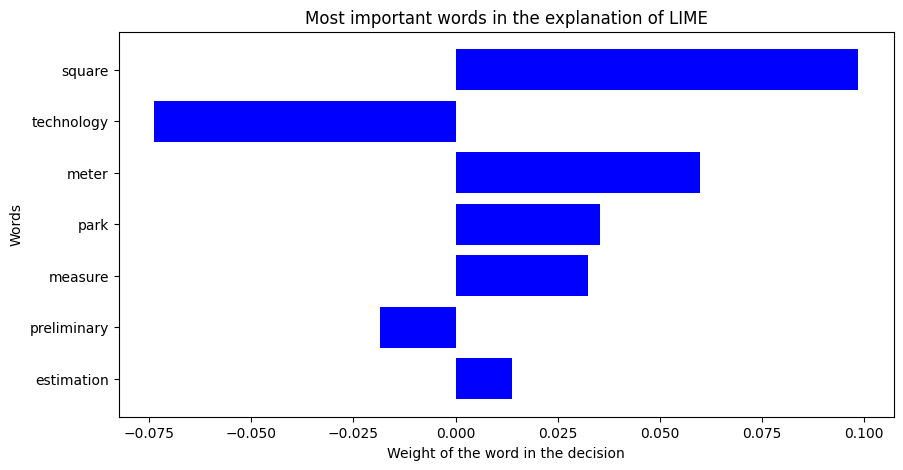

In [20]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [21]:
explanation_list = explanation.as_list()
lime_df = pd.DataFrame(explanation_list, columns=["Words", "Impact"])

# Ordenar por impacto
lime_df = lime_df.sort_values(by="Impact", ascending=False)

display(lime_df.head(20))  # Exibir as 20 palavras mais impactantes

,Words,Impact
0,square,0.098597
2,meter,0.059922
3,park,0.035293
4,measure,0.032437
6,estimation,0.013846
5,preliminary,-0.018499
1,technology,-0.073854


**Métricas**

In [22]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = pipeline.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.69      0.52      0.59       110
     neutral       0.77      0.89      0.82       571
    positive       0.71      0.55      0.62       289

    accuracy                           0.75       970
   macro avg       0.72      0.65      0.68       970
weighted avg       0.74      0.75      0.74       970



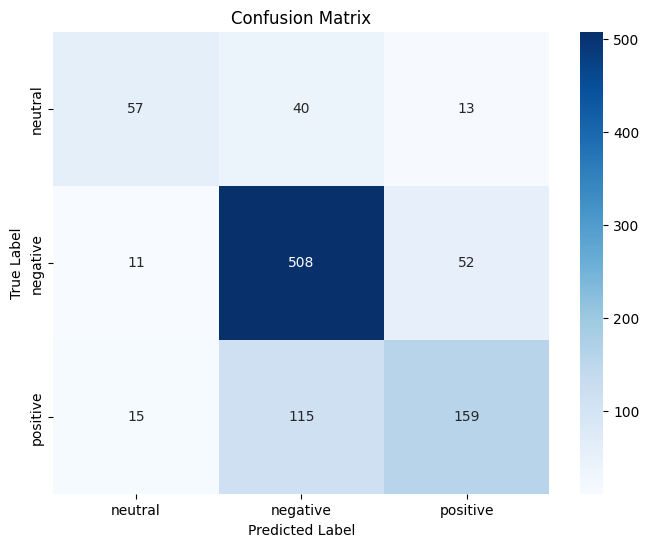

In [23]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=df["sentiment"].unique(), yticklabels=df["sentiment"].unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Usando 'weighted' para classes múltiplas
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Acuraccy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acuraccy: 0.7464
Precision: 0.7404
Recall: 0.7464
F1-Score: 0.7363


**Attention Vizualization**

A interpretação da atenção no SVM é diferente da interpretação em redes neurais. No SVM, a atenção é representada pela importância das features na decisão do modelo.

In [25]:
print(pipeline.classes_)

['negative' 'neutral' 'positive']


Palavras do exemplo e seus pesos na decisão da classe prevista:
          Feature    Weight
6338       square  0.823298
4119        meter  0.514783
4055      measure  0.459989
4796         park  0.410258
2087   estimation  0.214083
5119  preliminary  0.016549
6694   technology -0.726745


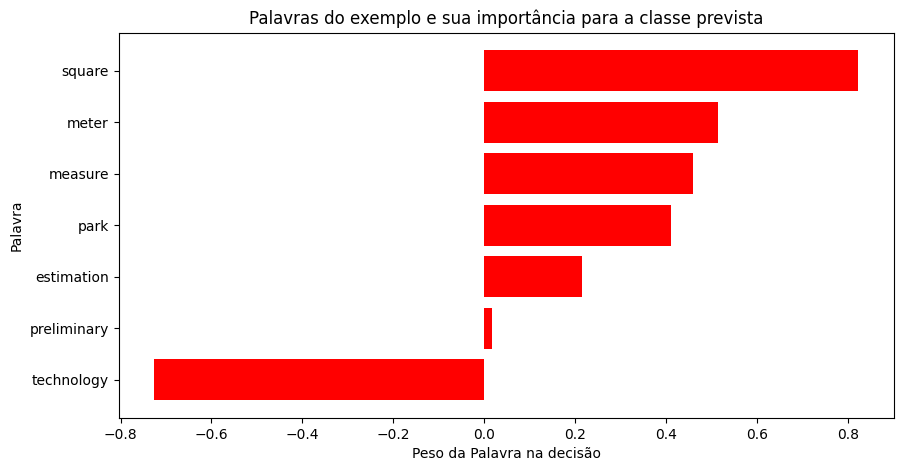

In [26]:
# Obter os nomes das features do CountVectorizer
feature_names = pipeline.named_steps['vect'].get_feature_names_out()

# Obter os coeficientes do SVM para a classe prevista
classe_prevista = pipeline.predict([sample_text])[0]
classe_idx = list(pipeline.classes_).index(classe_prevista)
pesos = pipeline.named_steps['clf'].coef_[classe_idx]

# Criar DataFrame com as features e pesos
importancias = pd.DataFrame({'Feature': feature_names, 'Weight': pesos})

# Marcar as palavras do exemplo
palavras_exemplo = set(sample_text.split())
importancias['No_Exemplo'] = importancias['Feature'].apply(lambda x: x in palavras_exemplo)

# Visualizar as palavras do exemplo e seus pesos
importancias_exemplo = importancias[importancias['No_Exemplo']].sort_values(by='Weight', ascending=False)

print("Palavras do exemplo e seus pesos na decisão da classe prevista:")
print(importancias_exemplo[['Feature', 'Weight']])

# Plotar as palavras do exemplo
plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo['Feature'], importancias_exemplo['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title("Palavras do exemplo e sua importância para a classe prevista")
plt.gca().invert_yaxis()
plt.show()

In [27]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[1]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

            Feature    Weight
7188          value  1.667371
2808  headquartered  1.627915
337   approximately  1.592193
3053       includes  1.533668
255           among  1.313397
4742      ownership  1.310216
4802           part  1.246122
1643    development  1.245699
898         capital  1.245542
1927    electricity  1.220082
4877        pension  1.172964
4565          offer  1.155968
1511           date  1.154311
5133        present  1.139742
4184         mining  1.123576
3051        include  1.085214
4654         option  1.066606
5364          range  1.065041
6369        started  1.064586
640              bg  1.061278


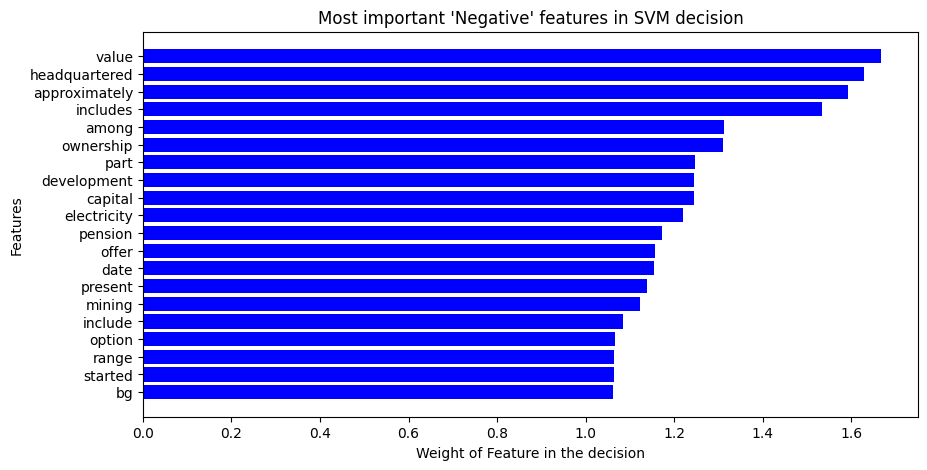

In [28]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Negative' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

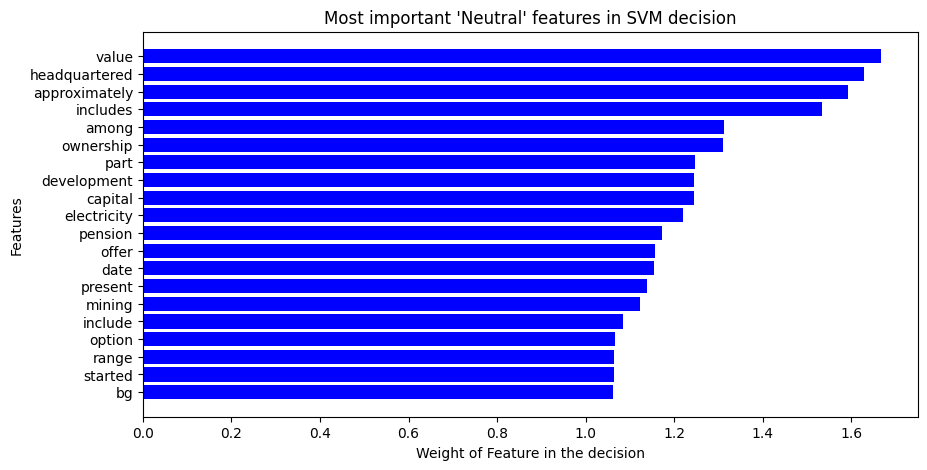

In [29]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Neutral' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [30]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[2]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

          Feature    Weight
5743         rose  3.276985
3063    increased  3.033884
3062     increase  2.928803
5072     positive  2.871762
2690         grew  2.852506
492       awarded  2.483588
6111       signed  2.470966
3035     improved  2.283739
5398        reach  2.200162
12           able  2.027030
2168       expand  1.973577
5353       raised  1.916282
3664      leading  1.874924
3036  improvement  1.846791
2171    expanding  1.834638
7553   yearonyear  1.792799
2704         grow  1.748220
4337     narrowed  1.719243
2709       growth  1.710104
5702         rise  1.687929


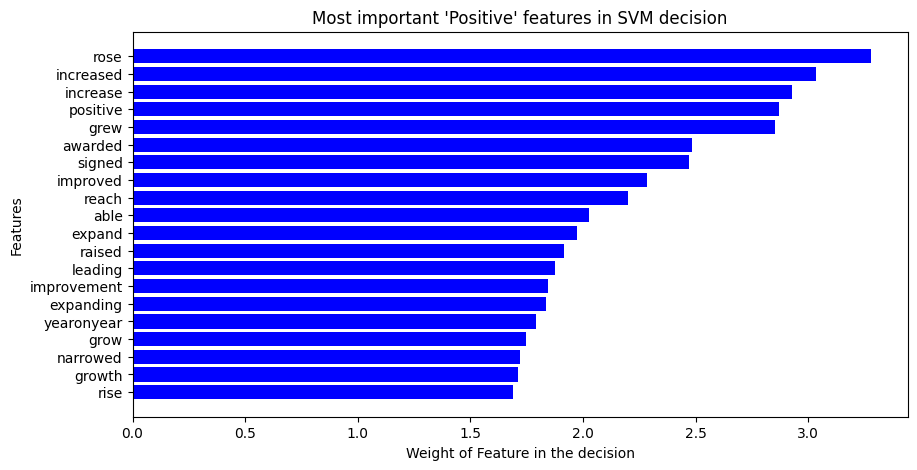

In [31]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Positive' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [33]:
# Contar a distribuição das classes em tabela
class_distribution = df['sentiment'].value_counts()
class_distribution2 = pd.Series(y_test).value_counts()

print("Distribuição das classes:")
print(class_distribution)

print("Distribuição das classes no conjunto de teste:")
print(class_distribution2)

Distribuição das classes:
sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64
Distribuição das classes no conjunto de teste:
sentiment
neutral     571
positive    289
negative    110
Name: count, dtype: int64
